# Set-Up

In [1]:
# Arvind Prasadan
# 2019 January
# DMF Package 
# Simulations

# DMF Package
push!(LOAD_PATH, "../src/")
using DMF

# Basic Linear Algebra Functionality
using LinearAlgebra
using Statistics
using StatsBase

# Plotting and Output
using Plots
using Measures
using LaTeXStrings

# File IO
using FileIO
using JLD2

# SOBI Wrapper Function 
using RCall
include("../src/SOBI_Wrapper.jl")

# Set plotting interface
ENV["MPLBACKEND"]="qt5agg"
pyplot()

┌ Info: Recompiling stale cache file /Users/arvind/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

## Reload Data

In [159]:
# To Load Data
tmp = load("data/synthetic_data.jld2")

n_list = tmp["n_list"]
k = tmp["k"]
p = tmp["p"]
p_missing = tmp["p_missing"]
q_list = tmp["q_list"]
sigma_list = tmp["sigma_list"]
f_first = tmp["f_first"]
f_second = tmp["f_second"]
fs = tmp["fs"]
arma_std = tmp["arma_std"]
ar = tmp["ar"]
ma = tmp["ma"]
trials = tmp["trials"]
trace_size = tmp["trace_size"]
cos_eigenvalue_error = tmp["cos_eigenvalue_error"]
cos_eigenvector_error = tmp["cos_eigenvector_error"]
cos_signal_error = tmp["cos_signal_error"]
arma_eigenvalue_error = tmp["arma_eigenvalue_error"]
arma_eigenvector_error = tmp["arma_eigenvector_error"]
arma_signal_error = tmp["arma_signal_error"]
a_trials = tmp["a_trials"]
ac_35 = tmp["ac_35"]
ac_27 = tmp["ac_27"]
cos_phase_eigenvalues = tmp["cos_phase_eigenvalues"]
cos_phase_eigenvalue_error = tmp["cos_phase_eigenvalue_error"]
cos_phase_eigenvector_error = tmp["cos_phase_eigenvector_error"]
cos_phase_signal_error = tmp["cos_phase_signal_error"]
cos_missing_eigenvalue_error = tmp["cos_missing_eigenvalue_error"]
cos_missing_eigenvector_error = tmp["cos_missing_eigenvector_error"]
cos_missing_signal_error = tmp["cos_missing_signal_error"]
cos_missing_n_eigenvalue_error = tmp["cos_missing_n_eigenvalue_error"]
cos_missing_n_eigenvector_error = tmp["cos_missing_n_eigenvector_error"]
cos_missing_n_signal_error = tmp["cos_missing_n_signal_error"]
lags = tmp["lags"]
cos_sobi_signal_error = tmp["cos_sobi_signal_error"]
cos_sobi_eigenvector_error = tmp["cos_sobi_eigenvector_error"];


## Parameters

In [108]:
n_list = Int.(round.(exp10.(range(log10(500.0); stop = 4.0, length = 10))))
n = maximum(n_list)

k = 2 # Number of modes

# Mode vectors
p = 100
p_missing = 500

# Missing Data Observation Probability
q_list = exp10.(range(-2.0; stop = 0.0, length = 15)) 

# Noise Variance
sigma_list = [0.0; exp10.(range(-2.0; stop = log10(2.0), length = 15))]
sigma_list = [sigma_list; 10.0.^(log10(2.0) .+ diff(log10.(sigma_list))[end] * (1:1:4))]

# Cosine Parameters
f_first = [0.25; 0.5]
f_second = [0.25; 2.0]
fs = 1.0

# ARMA Parameters
arma_std = 1.0
ar = [[0.2; 0.7], [0.3; 0.5]]
ma = [[], []]

trials = 200 # For missing data, noise, ARMA

trace_size = (400, 250); # For plotting

# Cosines

In [29]:
# Eigenvectors
Q = randn(p, k)
Q = mapslices(normalize, Q; dims = 1)

# Two time series
S1_full = [gen_cos_sequence(n_list[end], f_first[1], fs)[1] gen_cos_sequence(n_list[end], f_first[2], fs)[1]]
S2_full = [gen_cos_sequence(n_list[end], f_second[1], fs)[1] gen_cos_sequence(n_list[end], f_second[2], fs)[1]]

# Magnitudes
D = Diagonal([1.0; 1.0])

# True Eigenvalues
w1_true = sort(cos.(f_first))
w2_true = sort(cos.(f_second))

cos_eigenvalue_error = zeros(length(n_list), k, 2)
cos_eigenvector_error = zeros(length(n_list), 2)
cos_signal_error = zeros(length(n_list), 2)
for nn = 1:1:length(n_list) # Loop over signal length
    n = n_list[nn]
    
    S1 = mapslices(normalize, S1_full[1:n, :]; dims = 1)
    S2 = mapslices(normalize, S2_full[1:n, :]; dims = 1)
    
    X1 = Q * D * S1'
    X2 = Q * D * S2'
    
    w1, Q1, C1, A = dmf(X1; C_nsv = k, lag = 1)
    w2, Q2, C2, A = dmf(X2; C_nsv = k, lag = 1)

    # Compute (squared) error
    cos_eigenvalue_error[nn, :, 1] = (w1_true - sort(real.(w1[1:k]))[:]).^2.0
    cos_eigenvalue_error[nn, :, 2] = (w2_true - sort(real.(w2[1:k]))[:]).^2.0
    cos_eigenvector_error[nn, 1] = eigenvector_error(Q[:, 1:k], Q1[:, 1:k])
    cos_eigenvector_error[nn, 2] = eigenvector_error(Q[:, 1:k], Q2[:, 1:k])
    cos_signal_error[nn, 1] = eigenvector_error(S1[:, 1:k], C1[:, 1:k])
    cos_signal_error[nn, 2] = eigenvector_error(S2[:, 1:k], C2[:, 1:k])
end

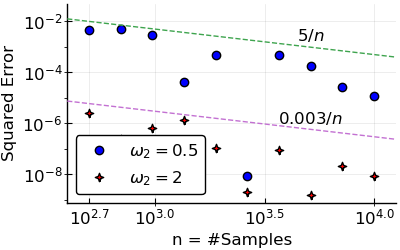

In [71]:
# Q ERROR
n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_eigenvector_error[:]) / 2, 10.0 * maximum(cos_eigenvector_error[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_eigenvector_error[:, 1], label = L"\omega_2 = 0.5", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_eigenvector_error[:, 2], label = L"\omega_2 = 2", marker = :star4, color = :red, markersize = 6)


boundline1 = (5.0 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
boundline2 =  (0.003 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline1[end - 4], L"5/n", 12))
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline2[end - 4], L"0.003/n", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)

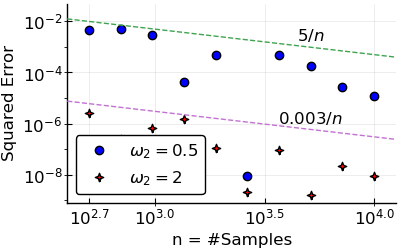

In [72]:
# S ERROR
n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_signal_error[:]) / 2, 10.0 * maximum(cos_signal_error[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_signal_error[:, 1], label = L"\omega_2 = 0.5", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_signal_error[:, 2], label = L"\omega_2 = 2", marker = :star4, color = :red, markersize = 6)


boundline1 = (5.0 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
boundline2 =  (0.003 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline1[end - 4], L"5/n", 12))
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline2[end - 4], L"0.003/n", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)

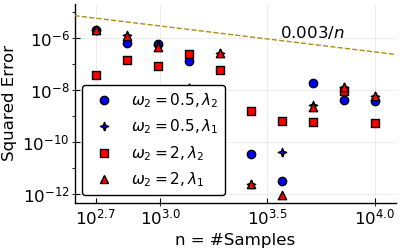

In [74]:
# Eigenvalue ERROR
n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_eigenvalue_error[:]) / 2, 10.0 * maximum(cos_eigenvalue_error[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_eigenvalue_error[:, 1, 1], label = L"\omega_2 = 0.5, \lambda_2", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_eigenvalue_error[:, 2, 1], label = L"\omega_2 = 0.5, \lambda_1", marker = :star4, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_eigenvalue_error[:, 1, 2], label = L"\omega_2 = 2, \lambda_2", marker = :square, color = :red, markersize = 6)
p1 = scatter!(n_list, cos_eigenvalue_error[:, 2, 2], label = L"\omega_2 = 2, \lambda_1", marker = :utriangle, color = :red, markersize = 6)

n_pl = [10^2.6; n_list; 10^4.1]
boundline1 = 0.003 * (1.0 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline2[end - 4], L"0.003/n", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = Plots.font("Helvetica", 11), guidefont = font, xtickfont = font, ytickfont = font)

# ARMA

In [38]:
# Eigenvectors
Q = randn(p, k)
Q = mapslices(normalize, Q; dims = 1)

# Magnitudes
D = Diagonal([1.0; 1.0])

# True Eigenvalues: Lag 1, Lag 2
w1_true = sort([0.6; 2.0 / 3.0])
w2_true = sort([0.68; 5.0 / 6.0])

arma_eigenvalue_error = zeros(length(n_list), k, 2, trials)
arma_eigenvector_error = zeros(length(n_list), 2, trials)
arma_signal_error = zeros(length(n_list), 2, trials)
for tr = 1:1:trials
    S_full = [gen_arma_sequence(n_list[end], ar[1], ma[1], arma_std) gen_arma_sequence(n_list[end], ar[2], ma[2], arma_std)] 
    
    for nn = 1:1:length(n_list) # Loop over signal length
        n = n_list[nn]

        S_inner = mapslices(normalize, S_full[1:n, :]; dims = 1)

        X = Q * D * S_inner'

        w1, Q1, C1, A = dmf(X; C_nsv = k, lag = 1)
        w2, Q2, C2, A = dmf(X; C_nsv = k, lag = 2)

        # Compute (squared) error
        arma_eigenvalue_error[nn, :, 1, tr] = (w1_true - sort(real.(w1[1:k]))[:]).^2.0
        arma_eigenvalue_error[nn, :, 2, tr] = (w2_true - sort(real.(w2[1:k]))[:]).^2.0
        arma_eigenvector_error[nn, 1, tr] = eigenvector_error(Q[:, 1:k], Q1[:, 1:k])
        arma_eigenvector_error[nn, 2, tr] = eigenvector_error(Q[:, 1:k], Q2[:, 1:k])
        arma_signal_error[nn, 1, tr] = eigenvector_error(S_inner[:, 1:k], C1[:, 1:k])
        arma_signal_error[nn, 2, tr] = eigenvector_error(S_inner[:, 1:k], C2[:, 1:k])
    end
end

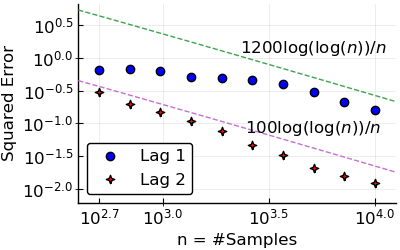

In [78]:
# Q ERROR
arma_eigenvector_error_m = dropdims(mean(arma_eigenvector_error; dims = 3); dims = 3)

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(arma_eigenvector_error_m[:]) / 2, 10.0 * maximum(arma_eigenvector_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, arma_eigenvector_error_m[:, 1], label = "Lag 1", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, arma_eigenvector_error_m[:, 2], label = "Lag 2", marker = :star4, color = :red, markersize = 6)


boundline1 = 1200 * (log.(log.(n_pl)) ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
boundline2 = 100 * (log.(log.(n_pl)) ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline1[end - 4], L"1200 \log(\log(n))/n", 12))
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline2[end - 3], L"100 \log(\log(n))/n", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)


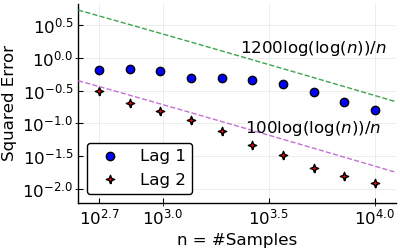

In [77]:
# S ERROR
arma_signal_error_m = dropdims(mean(arma_signal_error; dims = 3); dims = 3)

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(arma_signal_error_m[:]) / 2, 10.0 * maximum(arma_signal_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, arma_signal_error_m[:, 1], label = "Lag 1", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, arma_signal_error_m[:, 2], label = "Lag 2", marker = :star4, color = :red, markersize = 6)


boundline1 = 1200 * (log.(log.(n_pl)) ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
boundline2 = 100 * (log.(log.(n_pl)) ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline1[end - 4], L"1200 \log(\log(n))/n", 12))
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline2[end - 3], L"100 \log(\log(n))/n", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)

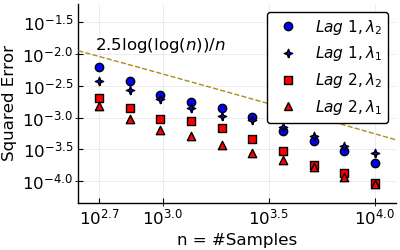

In [79]:
# Eigenvalue ERROR
arma_eigenvalue_error_m = dropdims(mean(arma_eigenvalue_error; dims = 4); dims = 4)

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(arma_eigenvalue_error_m[:]) / 2, 10.0 * maximum(arma_eigenvalue_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, arma_eigenvalue_error_m[:, 1, 1], label = L"Lag\,\,1, \lambda_2", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, arma_eigenvalue_error_m[:, 2, 1], label = L"Lag\,\,1, \lambda_1", marker = :star4, color = :blue, markersize = 6)
p1 = scatter!(n_list, arma_eigenvalue_error_m[:, 1, 2], label = L"Lag\,\,2, \lambda_2", marker = :square, color = :red, markersize = 6)
p1 = scatter!(n_list, arma_eigenvalue_error_m[:, 2, 2], label = L"Lag\,\,2, \lambda_1", marker = :utriangle, color = :red, markersize = 6)

n_pl = [10^2.6; n_list; 10^4.1]
boundline1 = 2.5 * (log.(log.(n_pl)) ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[4], 2 * boundline1[3], L"2.5 \log(\log(n))/n", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :topright, legendfont = Plots.font("Helvetica", 11), guidefont = font, xtickfont = font, ytickfont = font)


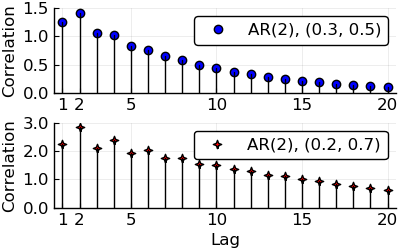

In [87]:
# Autocorrelation Function
"""
a_trials = 100

ac_35 = zeros(n_list[end])
ac_27 = zeros(n_list[end])

for tr = 1:1:a_trials
    ar35 = gen_arma_sequence(n_list[end], [0.3; 0.5], [], 1.0)
    ar27 = gen_arma_sequence(n_list[end], [0.2; 0.7], [], 1.0)
    
    ac_35 += autocorrelation(ar35)
    ac_27 += autocorrelation(ar27)
end
ac_35 /= a_trials
ac_27 /= a_trials
"""

p_idx = 1:20

p1 = plot(reuse = false, size = (trace_size[1], trace_size[2] / 2))
p1 = scatter!(p_idx, ac_35[p_idx .+ 1], label = "AR(2), (0.3, 0.5)", xlim = (p_idx[1] - 0.5, p_idx[end] + 0.5), ylim = (0, 1.5), markersize = 6, marker = :circle, color = :blue, ylabel = "Correlation", xticks = [1, 2, 5, 10, 15, 20])
for pp = 1:1:length(p_idx)
    p1 = plot!([p_idx[pp], p_idx[pp]], [0, ac_35[p_idx[pp] .+ 1]], label = "", color = :black)
end
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :topright, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)

p2 = plot(reuse = false, size = (trace_size[1], trace_size[2] / 2))
p2 = scatter!(p_idx, ac_27[p_idx .+ 1], label = "AR(2), (0.2, 0.7)", xlim = (p_idx[1] - 0.5, p_idx[end] + 0.5), ylim = (0, 3), markersize = 6, marker = :star4, color = :red, xlabel = "Lag", ylabel = "Correlation", yticks = ([0.0, 1.0, 2.0, 3.0], ["0.0", "1.0", "2.0", "3.0"]), xticks = [1, 2, 5, 10, 15, 20])
for pp = 1:1:length(p_idx)
    p2 = plot!([p_idx[pp], p_idx[pp]], [0, ac_27[p_idx[pp] .+ 1]], label = "", color = :black)
end
font = Plots.font("Helvetica", 12)
p2 = plot!(legend = :topright, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)

plot(p1, p2, layout = (2, 1), size = trace_size)



# Cosine: Randomized Phase

In [ ]:
# Eigenvectors
Q = randn(p, k)
Q = mapslices(normalize, Q; dims = 1)

# Magnitudes
D = Diagonal([1.0; 1.0])

phase_list = pi * (-1.0:0.1:1.0)

# True Eigenvalues
w2_true = sort(cos.(f_second))

cos_phase_eigenvalues = zeros(length(n_list), length(phase_list), length(phase_list), k) * Complex(0, 0)
cos_phase_eigenvector_error = zeros(length(n_list), length(phase_list), length(phase_list))
cos_phase_signal_error = zeros(length(n_list), length(phase_list), length(phase_list))

for p1 = 1:1:length(phase_list) # First phase
    ph1 = phase_list[p1]
    
    for p2 = 1:1:length(phase_list) # Second phase
        ph2 = phase_list[p2]
        
        S_full = [gen_cos_sequence(n_list[end], f_second[1], fs, ph1)[1] gen_cos_sequence(n_list[end], f_second[2], fs, ph2)[1]]
        
        for nn = 1:1:length(n_list) # Loop over signal length
            n = n_list[nn]

            S_inner = mapslices(normalize, S_full[1:n, :]; dims = 1)
            X = Q * D * S_inner'
            w1, Q1, C1, A = dmf(X; C_nsv = k, lag = 1)

            cos_phase_eigenvalues[nn, p1, p2, :] = w1[1:k]
            cos_phase_eigenvector_error[nn, p1, p2] = eigenvector_error(Q[:, 1:k], Q1[:, 1:k])
            cos_phase_signal_error[nn, p1, p2] = eigenvector_error(S_inner[:, 1:k], C1[:, 1:k])
        end
    end
end


In [14]:
cos_phase_eigenvalue_error = min.(abs.(cos_phase_eigenvalues .- w2_true[1]), abs.(cos_phase_eigenvalues .- w2_true[2])).^2.0;

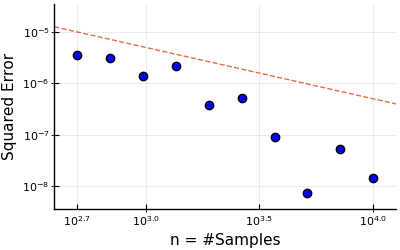

In [22]:
# Q ERROR
cos_phase_eigenvector_error_m = mapslices(maximum, cos_phase_eigenvector_error; dims = [2; 3])

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_phase_eigenvector_error_m[:]) / 2, 10.0 * maximum(cos_phase_eigenvector_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_phase_eigenvector_error_m[:, 1], label = "", marker = :circle, color = :blue, markersize = 6)

boundline2 =  (0.005 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)


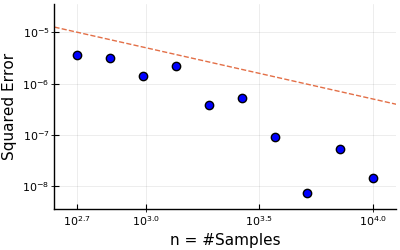

In [24]:
# S ERROR
cos_phase_signal_error_m = mapslices(maximum, cos_phase_signal_error; dims = [2; 3])
n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_phase_signal_error_m[:]) / 2, 10.0 * maximum(cos_phase_signal_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_phase_signal_error_m[:, 1], label = "", marker = :circle, color = :blue, markersize = 6)

boundline2 =  (0.005 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)


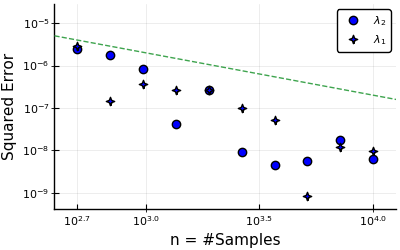

In [37]:
# Eigenvalue ERROR
cos_phase_eigenvalue_error_m = dropdims(mapslices(maximum, cos_phase_eigenvalue_error; dims = [2; 3]); dims = (2, 3))

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_phase_eigenvalue_error_m[:]) / 2, 10.0 * maximum(cos_phase_eigenvalue_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_phase_eigenvalue_error_m[:, 1], label = L"\lambda_2", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_phase_eigenvalue_error_m[:, 2], label = L"\lambda_1", marker = :star4, color = :blue, markersize = 6)

boundline1 = 0.002 * (1.0 ./ n_pl).^(1.0)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)


# Missing Data

In [281]:
# Fixing observation probability 

e_val_err_fcn = (truth, est) -> (est = real.(est); 
    min.(abs.(truth - sort(est)), 
        abs.(truth + sort(est)), 
        abs.(truth - sort(est; rev = true)), 
        abs.(truth + sort(est; rev = true))).^2
)

p_missing = 2000
trials = 50

# Magnitudes
D = Diagonal([2.0; 1.0])

# True Eigenvalues
w2_true = sort(cos.(f_second))

cos_missing_eigenvalue_error = zeros(length(n_list), k, 2, trials)
cos_missing_eigenvector_error = zeros(length(n_list), 2, trials)
cos_missing_signal_error = zeros(length(n_list), 2, trials)

S_full = [gen_cos_sequence(n_list[end], f_second[1], fs)[1] gen_cos_sequence(n_list[end], f_second[2], fs)[1]]

q_fix = 0.1
t1 = time()
for nn = 1:1:length(n_list) # Loop over signal length
    n = n_list[nn]
    S_inner = mapslices(normalize, S_full[1:n, :]; dims = 1)
    
    for tr = 1:1:trials
        # Eigenvectors
        # Q = randn(p_missing, k)
        # Q = mapslices(normalize, Q; dims = 1)
        Q = qr(randn(p_missing, k)).Q[:, 1:k]
        
        X = (Q * D) * S_inner'
        
        mask = float.(rand(p_missing, n) .<= q_fix)
        Xm = X .* mask
    
        # DMD v. tSVD + DMD
        w1, Q1, C1, _ = dmf(Xm; tsvd = false, nsv = k, C_nsv = k, lag = 1)
        w2, Q2, C2, _ = dmf(Xm; tsvd = true, nsv = k, C_nsv = k, lag = 1)
        
        # Compute (squared) error
        cos_missing_eigenvalue_error[nn, :, 1, tr] = e_val_err_fcn(w2_true, w1[1:k]) 
        cos_missing_eigenvector_error[nn, 1, tr] = eigenvector_error(Q[:, 1:k], Q1[:, 1:k])
        cos_missing_signal_error[nn, 1, tr] = eigenvector_error(S_inner[:, 1:k], C1[:, 1:k])
        
        cos_missing_eigenvalue_error[nn, :, 2, tr] = e_val_err_fcn(w2_true, w2[1:k])
        cos_missing_eigenvector_error[nn, 2, tr] = eigenvector_error(Q[:, 1:k], Q2[:, 1:k])
        cos_missing_signal_error[nn, 2, tr] = eigenvector_error(S_inner[:, 1:k], C2[:, 1:k])
    end
end
t2 = time()
println(t2 - t1)

11752.775175094604


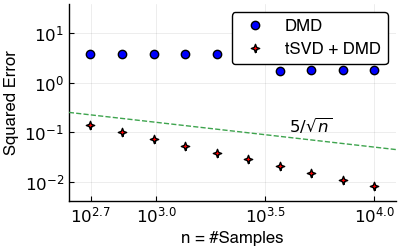

In [282]:
# Q ERROR
cos_missing_eigenvector_error_m = dropdims(mean(cos_missing_eigenvector_error; dims = 3); dims = 3)

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_missing_eigenvector_error_m[:]) / 2, 10.0 * maximum(cos_missing_eigenvector_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_missing_eigenvector_error_m[:, 1], label = "DMD", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_missing_eigenvector_error_m[:, 2], label = "tSVD + DMD", marker = :star4, color = :red, markersize = 6)

boundline2 = 5 * (1 ./ n_pl).^(0.5)
p1 = plot!(n_pl, boundline2, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 2 * boundline2[end - 3], L"5 / \sqrt{n}", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :topright, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)


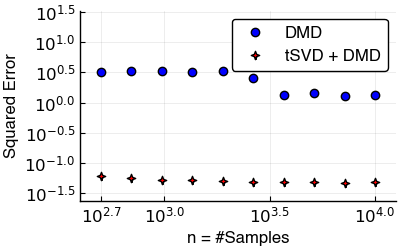

In [283]:
# S ERROR
cos_missing_signal_error_m = dropdims(mean(cos_missing_signal_error; dims = 3); dims = 3)

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_missing_signal_error_m[:]) / 2, 10.0 * maximum(cos_missing_signal_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_missing_signal_error_m[:, 1], label = "DMD", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_missing_signal_error_m[:, 2], label = "tSVD + DMD", marker = :star4, color = :red, markersize = 6)
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :topright, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)



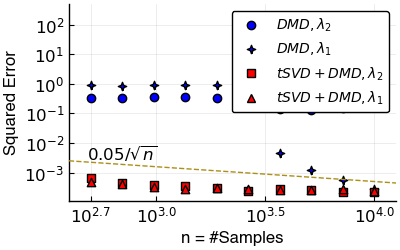

In [284]:
# Eigenvalue ERROR
cos_missing_eigenvalue_error_m = dropdims(maximum(cos_missing_eigenvalue_error; dims = 4); dims = 4)

n_pl = [10^2.6; n_list; 10^4.1]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_missing_eigenvalue_error_m[:]) / 2, 500.0),# * maximum(cos_missing_eigenvalue_error_m[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error", 
    xticks = [10^2.7, 10^3.0, 10^3.5, 10^4.0]
)
p1 = scatter!(n_list, cos_missing_eigenvalue_error_m[:, 1, 1], label = L"DMD,\lambda_2", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_missing_eigenvalue_error_m[:, 2, 1], label = L"DMD, \lambda_1", marker = :star4, color = :blue, markersize = 6)
p1 = scatter!(n_list, cos_missing_eigenvalue_error_m[:, 1, 2], label = L"tSVD + DMD,\lambda_2", marker = :square, color = :red, markersize = 6)
p1 = scatter!(n_list, cos_missing_eigenvalue_error_m[:, 2, 2], label = L"tSVD + DMD, \lambda_1", marker = :utriangle, color = :red, markersize = 6)

boundline1 = 0.050 * (1.0 ./ n_pl).^(0.5)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[3], 2.5 * boundline1[3], L"0.05 / \sqrt{n}", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :topright, legendfont = Plots.font("Helvetica", 10), guidefont = font, xtickfont = font, ytickfont = font)


## Fixed n

In [204]:
# Fixing sample size

e_val_err_fcn = (truth, est) -> (est = real.(est); 
    min.(abs.(truth - sort(est)), 
        abs.(truth + sort(est)), 
        abs.(truth - sort(est; rev = true)), 
        abs.(truth + sort(est; rev = true))).^2
)

p_missing = 2000
trials = 20

# Magnitudes
D = Diagonal([2.0; 1.0])

# True Eigenvalues
w2_true = sort(cos.(f_second))

cos_missing_n_eigenvalue_error = zeros(length(q_list), k, 2, trials)
cos_missing_n_eigenvector_error = zeros(length(q_list), 2, trials)
cos_missing_n_signal_error = zeros(length(q_list), 2, trials)

S_full = [gen_cos_sequence(n_list[end], f_second[1], fs)[1] gen_cos_sequence(n_list[end], f_second[2], fs)[1]]

t1 = time()
for qq = 1:1:length(q_list) # Loop over signal length
    q = q_list[qq]
    
    # Eigenvectors
    Q = randn(p_missing, k)
    Q = mapslices(normalize, Q; dims = 1)
    X = Q * D * S_full'

    for tr = 1:1:trials
        mask = float.(rand(p_missing, n_list[end]) .<= q)
        Xm = X .* mask
    
        # DMD v. tSVD + DMD
        w1, Q1, C1, A = dmf(Xm; tsvd = false, nsv = k, C_nsv = k, lag = 1)
        w2, Q2, C2, A = dmf(Xm; tsvd = true, nsv = k, C_nsv = k, lag = 1)
        
        # Compute (squared) error
        cos_missing_n_eigenvalue_error[qq, :, 1, tr] = e_val_err_fcn(w2_true, w1[1:k]) # (w2_true - sort(real.(w1[1:k]))[:]).^2.0
        cos_missing_n_eigenvector_error[qq, 1, tr] = eigenvector_error(Q[:, 1:k], Q1[:, 1:k])
        cos_missing_n_signal_error[qq, 1, tr] = eigenvector_error(S_full[:, 1:k], C1[:, 1:k])
        
        cos_missing_n_eigenvalue_error[qq, :, 2, tr] = e_val_err_fcn(w2_true, w2[1:k]) # (w2_true - sort(real.(w2[1:k]))[:]).^2.0
        cos_missing_n_eigenvector_error[qq, 2, tr] = eigenvector_error(Q[:, 1:k], Q2[:, 1:k])
        cos_missing_n_signal_error[qq, 2, tr] = eigenvector_error(S_full[:, 1:k], C2[:, 1:k])
    end
end
t2 = time()
println(t2 - t1)

12437.936420917511


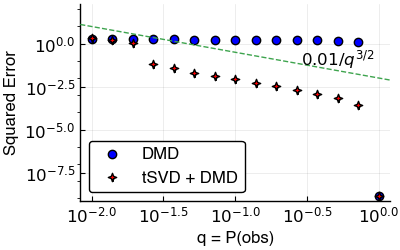

In [219]:
# Q ERROR
cos_missing_n_eigenvector_error_m = dropdims(mean(cos_missing_n_eigenvector_error; dims = 3); dims = 3)

n_pl = [q_list[1] / 1.2; q_list; 1.2]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_missing_n_eigenvector_error_m[:]) / 2, 100.0 * maximum(cos_missing_n_eigenvector_error_m[:])), 
    xlabel = "q = P(obs)", ylabel = "Squared Error"
)
p1 = scatter!(q_list, cos_missing_n_eigenvector_error_m[:, 1], label = "DMD", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(q_list, cos_missing_n_eigenvector_error_m[:, 2], label = "tSVD + DMD", marker = :star4, color = :red, markersize = 6)

boundline1 = 0.01 * (1.0 ./ n_pl).^(1.5)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[end - 3], 0.6 * boundline1[10], L"0.01 / q^{3/2}", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)


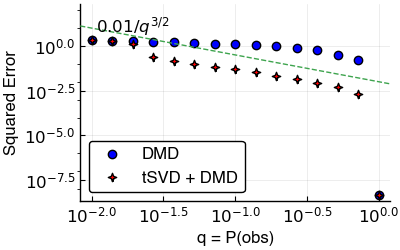

In [224]:
# S ERROR
cos_missing_n_signal_error_m = dropdims(mean(cos_missing_n_signal_error; dims = 3); dims = 3)

n_pl = [q_list[1] / 1.2; q_list; 1.2]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_missing_n_signal_error_m[:]) / 2, 100.0 * maximum(cos_missing_n_signal_error_m[:])), 
    xlabel = "q = P(obs)", ylabel = "Squared Error"
)
p1 = scatter!(q_list, cos_missing_n_signal_error_m[:, 1], label = "DMD", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(q_list, cos_missing_n_signal_error_m[:, 2], label = "tSVD + DMD", marker = :star4, color = :red, markersize = 6)

boundline1 = 0.01 * (1.0 ./ n_pl).^(1.5)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[4], 2 * boundline1[3], L"0.01 / q^{3/2}", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)


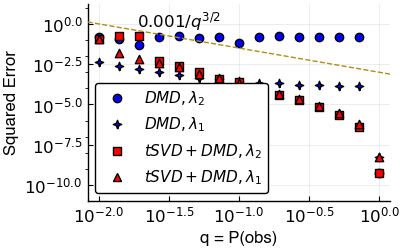

In [278]:
# Eigenvalue ERROR
cos_missing_n_eigenvalue_error_m = dropdims(maximum(cos_missing_n_eigenvalue_error; dims = 4); dims = 4)

n_pl = [q_list[1] / 1.2; q_list; 1.2]

p1 = plot(reuse = false, size = trace_size, markersize = 6, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_missing_n_eigenvalue_error_m[:]) / 50, 100.0 * maximum(cos_missing_n_eigenvalue_error_m[:])), 
    xlabel = "q = P(obs)", ylabel = "Squared Error"
)
p1 = scatter!(q_list, cos_missing_n_eigenvalue_error_m[:, 1, 1], label = L"DMD,\lambda_2", marker = :circle, color = :blue, markersize = 6)
p1 = scatter!(q_list, cos_missing_n_eigenvalue_error_m[:, 2, 1], label = L"DMD, \lambda_1", marker = :star4, color = :blue, markersize = 6)
p1 = scatter!(q_list, cos_missing_n_eigenvalue_error_m[:, 1, 2], label = L"tSVD + DMD,\lambda_2", marker = :square, color = :red, markersize = 6)
p1 = scatter!(q_list, cos_missing_n_eigenvalue_error_m[:, 2, 2], label = L"tSVD + DMD, \lambda_1", marker = :utriangle, color = :red, markersize = 6)

boundline1 = 0.001 * (1.0 ./ n_pl).^(1.5)
p1 = plot!(n_pl, boundline1, label = "", linestyle = :dash)
p1 = plot!(ann = (n_pl[6], 10 * boundline1[6], L"0.001 / q^{3/2}", 12))
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = Plots.font("Helvetica", 11), guidefont = font, xtickfont = font, ytickfont = font)


# SOBI Comparison

In [4]:
# Eigenvectors
Q = randn(p_missing, k)
Q = mapslices(normalize, Q; dims = 1)

# Magnitudes
D = Diagonal([2.0; 1.0])

# True Eigenvalues
w2_true = sort(cos.(f_second))

lags = 1
cos_sobi_signal_error = zeros(length(n_list), 2)
cos_sobi_eigenvector_error = zeros(length(n_list), 2)

S_full = [gen_cos_sequence(n_list[end], f_second[1], fs)[1] gen_cos_sequence(n_list[end], f_second[2], fs)[1]]

for nn = 1:1:length(n_list)
    n = n_list[nn]
    
    S_inner = mapslices(normalize, S_full[1:n, :]; dims = 1)
    X = Q * D * S_inner'

    # DMD
    _, Q_DMD, S_DMD, _ = dmf(X; C_nsv = k)
    
    # SOBI
    Q_SOBI, S_SOBI = SOBI_Wrapper(X, lags)
    
    cos_sobi_signal_error[nn, 1] = eigenvector_error(S_inner[:, 1:k], S_DMD[:, 1:k])
    cos_sobi_signal_error[nn, 2] = eigenvector_error(S_inner[:, 1:k], S_SOBI[:, 1:k])
    
    cos_sobi_eigenvector_error[nn, 1] = eigenvector_error(Q[:, 1:k], Q_DMD[:, 1:k])
    cos_sobi_eigenvector_error[nn, 2] = eigenvector_error(Q[:, 1:k], Q_SOBI[:, 1:k])
end


┌ Warning: RCall.jl: Warning in jedi(M, A0, eps, itermax, keepTrace) :
│   Convergence not reached
└ @ RCall /Users/arvind/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning: RCall.jl: Warning in jedi(M, A0, eps, itermax, keepTrace) :
│   Convergence not reached
└ @ RCall /Users/arvind/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning: RCall.jl: Warning in jedi(M, A0, eps, itermax, keepTrace) :
│   Convergence not reached
└ @ RCall /Users/arvind/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning: RCall.jl: Warning in jedi(M, A0, eps, itermax, keepTrace) :
│   Convergence not reached
└ @ RCall /Users/arvind/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning: RCall.jl: Warning in jedi(M, A0, eps, itermax, keepTrace) :
│   Convergence not reached
└ @ RCall /Users/arvind/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning: RCall.jl: Warning in jedi(M, A0, eps, itermax, keepTrace) :
│   Convergence not reached
└ @ RCall /Users/arvind/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning:

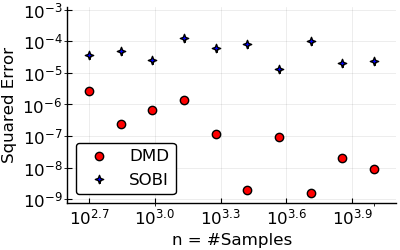

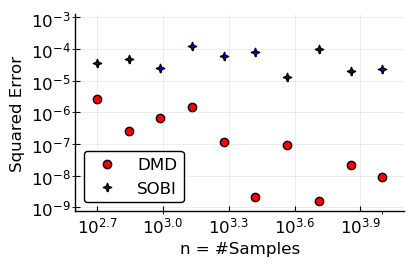

In [66]:
markers = [:circle, :star4]
colors = [:red, :blue]
labels = ["DMD", "SOBI"]
n_pl = [10^2.6; n_list; 10^4.1]

cos_sobi_signal_error[isnan.(cos_sobi_signal_error)] .= 2 * k
cos_sobi_eigenvector_error[isnan.(cos_sobi_eigenvector_error)] .= 2 * k

p1 = plot(reuse = false, size = trace_size, markersize = 8, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_sobi_signal_error[:]) / 2, 10.0 * maximum(cos_sobi_signal_error[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error"
)
for p_idx = 1:1:length(labels)
    p1 = scatter!(n_list, cos_sobi_signal_error[:, p_idx], label = labels[p_idx], marker = markers[p_idx], color = colors[p_idx], markersize = 6)
end
font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)

display(plot(p1))

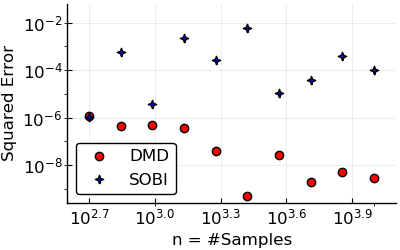

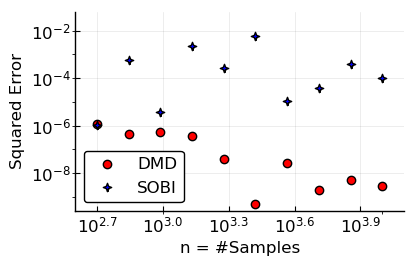

In [68]:
markers = [:circle, :star4]
colors = [:red, :blue]
labels = ["DMD", "SOBI"]
n_pl = [10^2.6; n_list; 10^4.1]

cos_sobi_eigenvector_error[isnan.(cos_sobi_eigenvector_error)] .= 2 * k

p1 = plot(reuse = false, size = trace_size, markersize = 10, 
    yscale = :log10, xscale = :log10, 
    xlim = (minimum(n_pl), maximum(n_pl)), 
    ylim = (minimum(cos_sobi_eigenvector_error[:]) / 2, 10.0 * maximum(cos_sobi_eigenvector_error[:])), 
    xlabel = "n = #Samples", ylabel = "Squared Error"
)
for p_idx = 1:1:length(labels)
    p1 = scatter!(n_list, cos_sobi_eigenvector_error[:, p_idx], label = labels[p_idx], marker = markers[p_idx], color = colors[p_idx], markersize = 6)
end

font = Plots.font("Helvetica", 12)
p1 = plot!(legend = :bottomleft, legendfont = font, guidefont = font, xtickfont = font, ytickfont = font)
display(plot(p1))

# Clean-Up

In [39]:
save("data/synthetic_data.jld2", 
            Dict("n_list" => n_list,
            "k" => k,
            "p" => p,
            "p_missing" => p_missing,
            "q_list" => q_list,
            "sigma_list" => sigma_list,
            "f_first" => f_first,
            "f_second" => f_second,
            "fs" => fs,
            "arma_std" => arma_std,
            "ar" => ar,
            "ma" => ma,
            "trials" => trials,
            "trace_size" => trace_size,
            "cos_eigenvalue_error" => cos_eigenvalue_error,
            "cos_eigenvector_error" => cos_eigenvector_error,
            "cos_signal_error" => cos_signal_error,
            "arma_eigenvalue_error" => arma_eigenvalue_error,
            "arma_eigenvector_error" => arma_eigenvector_error,
            "arma_signal_error" => arma_signal_error,
            "a_trials" => a_trials,
            "ac_35" => ac_35,
            "ac_27" => ac_27,
            "cos_phase_eigenvalues" => cos_phase_eigenvalues,
            "cos_phase_eigenvalue_error" => cos_phase_eigenvalue_error,
            "cos_phase_eigenvector_error" => cos_phase_eigenvector_error,
            "cos_phase_signal_error" => cos_phase_signal_error,
            "cos_missing_eigenvalue_error" => cos_missing_eigenvalue_error,
            "cos_missing_eigenvector_error" => cos_missing_eigenvector_error,
            "cos_missing_signal_error" => cos_missing_signal_error,
            "cos_missing_n_eigenvalue_error" => cos_missing_n_eigenvalue_error,
            "cos_missing_n_eigenvector_error" => cos_missing_n_eigenvector_error,
            "cos_missing_n_signal_error" => cos_missing_n_signal_error,
            "lags" => lags,
            "cos_sobi_signal_error" => cos_sobi_signal_error,
            "cos_sobi_eigenvector_error" => cos_sobi_eigenvector_error)
)